In [1]:
import warnings

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.impute import KNNImputer
from category_encoders import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline, make_pipeline

warnings.filterwarnings('ignore')

### Column id
1. ID: unique identifier
2. N_Days: number of days between registration and the earlier of death, transplantation, or study analysis time in July 1986
3. Status: status of the patient C (censored), CL (censored due to liver tx), or D (death)
4. Drug: type of drug D-penicillamine or placebo
5. Age: age in [days]
6. Sex: M (male) or F (female)
7. Ascites: presence of ascites N (No) or Y (Yes)
8. Hepatomegaly: presence of hepatomegaly N (No) or Y (Yes)
9. Spiders: presence of spiders N (No) or Y (Yes)
10. Edema: presence of edema N (no edema and no diuretic therapy for edema), S (edema present without diuretics, or edema resolved by diuretics), or Y (edema despite diuretic therapy)
11. Bilirubin: serum bilirubin in [mg/dl]
12. Cholesterol: serum cholesterol in [mg/dl]
13. Albumin: albumin in [gm/dl]
14. Copper: urine copper in [ug/day]
15. Alk_Phos: alkaline phosphatase in [U/liter]
16. SGOT: SGOT in [U/ml]
17. Triglycerides: triglicerides in [mg/dl]
18. Platelets: platelets per cubic [ml/1000]
19. Prothrombin: prothrombin time in seconds [s]
20. Stage: histologic stage of disease (1, 2, 3, or 4)

### Cirrhosis Definition
Cirrhosis is severe scarring of the liver. This serious condition can be caused by many forms of liver diseases and conditions, such as hepatitis or chronic alcoholism.

Each time your liver is injured — whether by excessive alcohol consumption or another cause, such as infection — it tries to repair itself. In the process, scar tissue forms. As cirrhosis gets worse, more and more scar tissue forms, making it difficult for the liver to do its job. Advanced cirrhosis is life-threatening.

The liver damage caused by cirrhosis generally can't be undone. But if liver cirrhosis is diagnosed early and the underlying cause is treated, further damage can be limited. In rare cases, it may be reversed.

In [2]:
def wrangle(filepath):
    df = pd.read_csv(filepath).set_index('ID')
    
    # Converting ages from days to years
    df.Age =round(df['Age'] / 365)
    
    # dropping null values
    df.dropna(inplace=True)
    
    return df

In [3]:
df = wrangle('cirrhosis.csv')

In [4]:
df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
ID,,,,,,,,,,,,,,,,,,,
1,400,D,D-penicillamine,59.0,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
2,4500,C,D-penicillamine,56.0,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
3,1012,D,D-penicillamine,70.0,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
4,1925,D,D-penicillamine,55.0,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
5,1504,CL,Placebo,38.0,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [5]:
df.shape

(276, 19)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276 entries, 1 to 312
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         276 non-null    int64  
 1   Status         276 non-null    object 
 2   Drug           276 non-null    object 
 3   Age            276 non-null    float64
 4   Sex            276 non-null    object 
 5   Ascites        276 non-null    object 
 6   Hepatomegaly   276 non-null    object 
 7   Spiders        276 non-null    object 
 8   Edema          276 non-null    object 
 9   Bilirubin      276 non-null    float64
 10  Cholesterol    276 non-null    float64
 11  Albumin        276 non-null    float64
 12  Copper         276 non-null    float64
 13  Alk_Phos       276 non-null    float64
 14  SGOT           276 non-null    float64
 15  Tryglicerides  276 non-null    float64
 16  Platelets      276 non-null    float64
 17  Prothrombin    276 non-null    float64
 18  Stage     

In [7]:
df.describe()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000
mean,1979.166667,49.836957,3.333696,371.260870,3.516812,100.768116,1996.611594,124.119239,124.978261,261.771739,10.735507,3.039855
std,1112.380295,10.529208,4.601074,234.788363,0.404789,88.268746,2115.477894,56.719952,65.280761,93.128857,1.008315,0.853999
min,41.000000,26.000000,0.300000,120.000000,1.960000,4.000000,289.000000,28.380000,33.000000,62.000000,9.000000,1.000000
25%,1185.750000,41.750000,0.800000,249.500000,3.310000,42.750000,922.500000,82.457500,85.000000,200.000000,10.000000,2.000000
50%,1788.000000,50.000000,1.400000,310.000000,3.545000,74.000000,1277.500000,116.625000,108.000000,257.000000,10.600000,3.000000
75%,2689.750000,57.000000,3.525000,401.000000,3.772500,129.250000,2068.250000,153.450000,151.250000,318.250000,11.200000,4.000000
max,4556.000000,78.000000,28.000000,1775.000000,4.400000,588.000000,13862.400000,457.250000,598.000000,563.000000,17.100000,4.000000


## Exploratory Data Analysis and Data Visualization

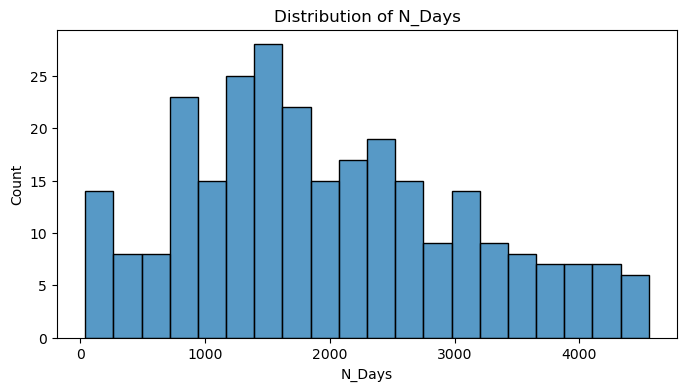

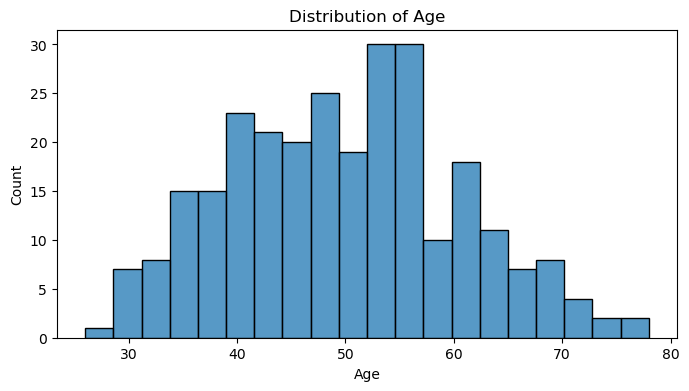

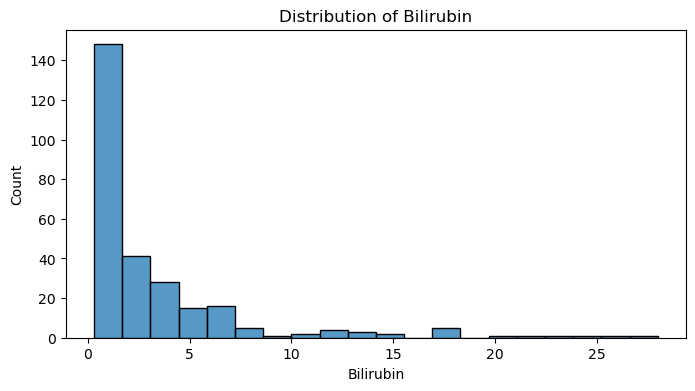

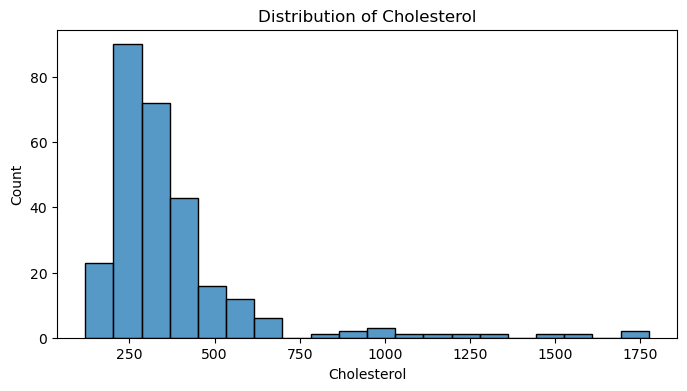

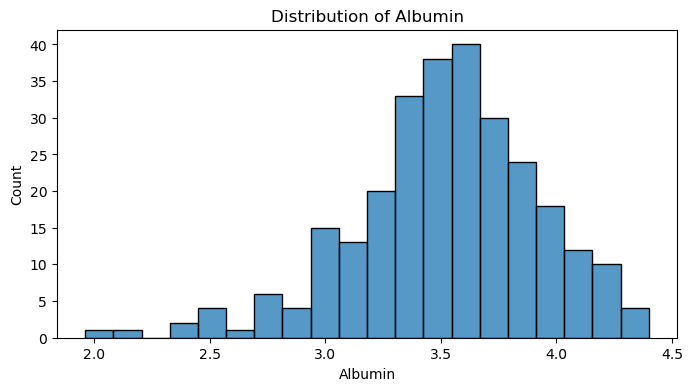

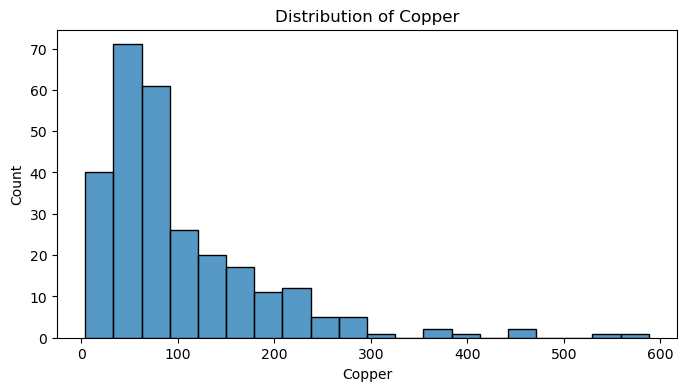

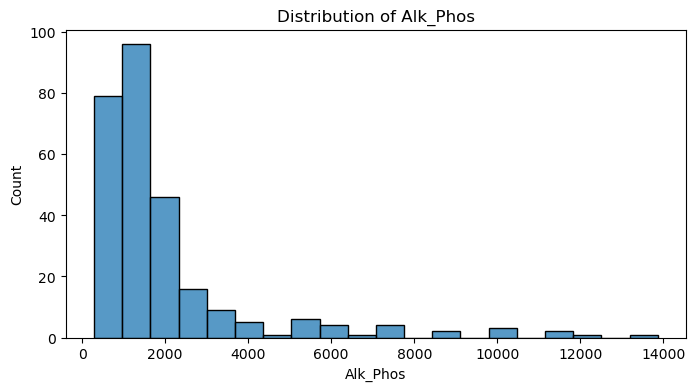

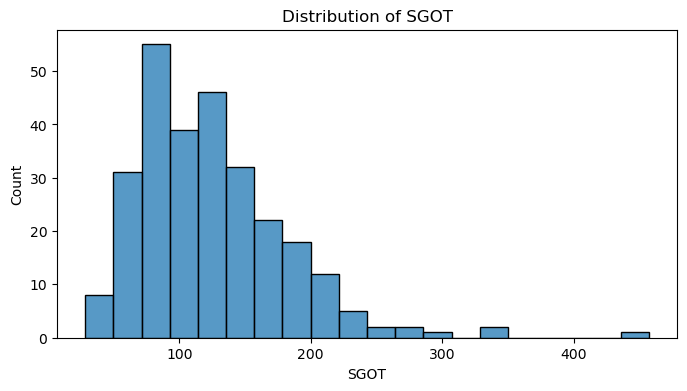

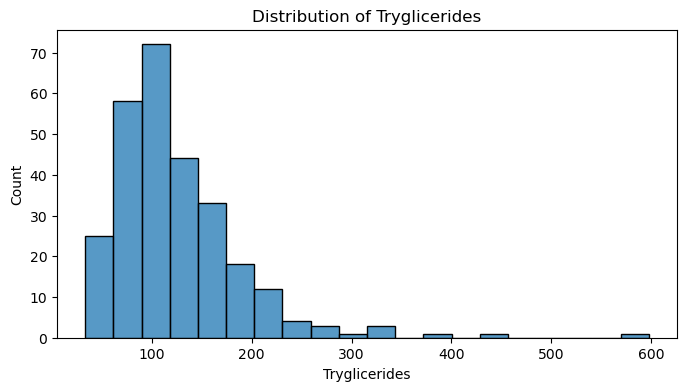

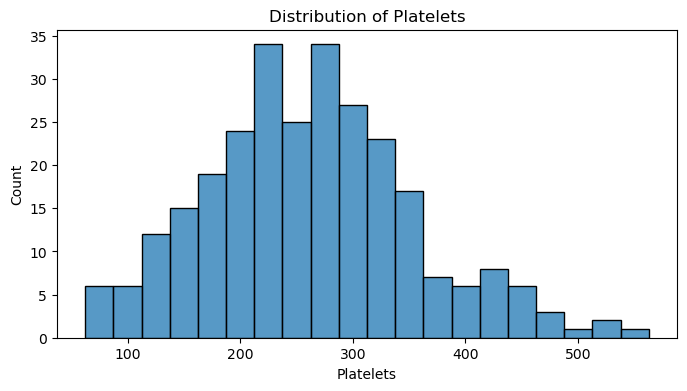

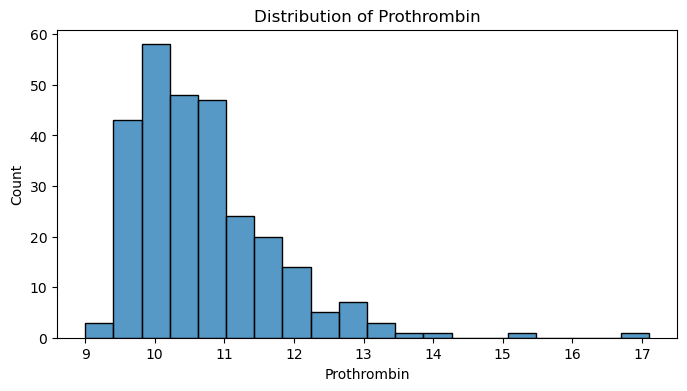

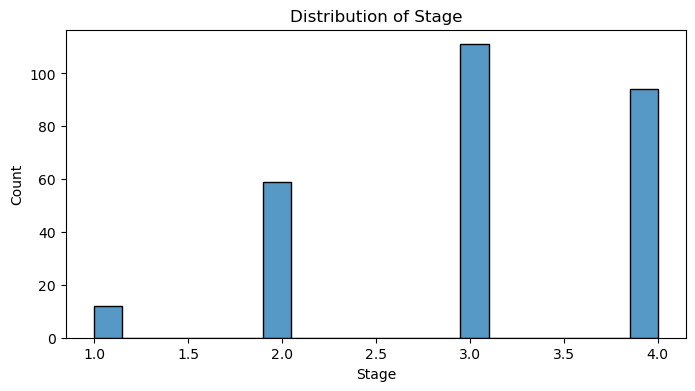

In [8]:
num_col = df.select_dtypes('number')
for col in num_col:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df, x=col, bins=20)
    plt.title(f'Distribution of {col}')
    plt.show()


#### Bilirubin
Bilirubin (bil-ih-ROO-bin) is a yellowish pigment that is made during the breakdown of red blood cells. Bilirubin passes through the liver and is eventually excreted out of the body. Higher than usual levels of bilirubin may indicate different types of liver or bile duct problems. It is normal to have some bilirubin in the blood. A normal level is: Direct (also called conjugated) bilirubin: less than 0.3 mg/dL (less than 5.1 µmol/L) Total bilirubin: 0.1 to 1.2 mg/dL (1.71 to 20.5 µmol/L)

#### Cholesterol
Cholesterol is a waxy, fat-like substance that circulates in your bloodstream. It helps to form protective layers, called cell membranes, around the cells in your body. It’s also necessary to make vitamin D, certain hormones, and bile, which helps you digest foods. Your liver makes all the cholesterol you need. Just as excess cholesterol in your blood can damage the liver.
Liver problems can have significant effects on cholesterol metabolism in the body, leading to the development of high cholesterol levels.Here are the ranges for total cholesterol in adults: Normal: Less than 200 mg/dL. Borderline high: 200 to 239 mg/dL.

#### Albumin
Your liver makes albumin. Albumin keeps fluid from leaking out of your bloodstream. It also helps vitamins, enzymes, hormones and other substances circulate throughout your body.
The normal range is 3.5 to 5.5 g/dL or 35-55 g/liter. This range may vary slightly in different laboratories.
Albumin composes 50%-60% of blood plasma proteins.

#### Copper
Copper is an essential trace element that is included in some over-the-counter multivitamin and mineral supplements, even though copper deficiency is quite rare and supplementation is rarely needed. The amounts of copper found in typical supplements has not been associated with serum enzyme elevations or with clinically apparent liver injury. However, accidental or intentional copper overdose can cause an acute liver injury and chronic ingestion of excessive amounts of copper can result in copper overload and chronic liver injury. Wilson's disease (WD) is a genetic disorder of copper metabolism. Patients accumulate copper in the liver as well as other organs. The normal range for total copper in the blood is 62 to 140 micrograms per deciliter (mcg/dL)

#### Alk_phos
Alkaline phosphatase (ALP) is an enzyme in blood that helps break down proteins. An ALP test measures how much ALP is circulating in the bloodstream. Having high or low ALP levels can indicate an underlying condition. The normal range is 44 to 147 international units per liter (IU/L) or 0.73 to 2.45 microkatal per liter (µkat/L).

#### SGOT
Serum glutamic-oxaloacetic transaminase, or SGOT. AST is a protein made by liver cells. When liver cells are damaged, AST leaks out into the bloodstream and the level of AST in the blood becomes elevated. The normal range of an SGOT test is generally between 8 and 45 units per liter of serum.

#### Tryglycerides
High triglyceride levels can be a clue that you have fatty liver disease. Poor eating habits lead not only to high levels of fat in the bloodstream (triglycerides) but increased storage of fat throughout the body, including in the liver.
Triglyceride levels usually fall into the following categories: Healthy: Below 150 milligrams per deciliter (mg/dL) for adults; lower than 90 mg/dL for children and teens (ages 10-19) Borderline high: Between 150 and 199 mg/dL. High: Between 200 and 499 mg/dL.

#### Platelet
The platelet count decreases with worsening liver disease, but the absolute number correlates poorly with bleeding outcomes. In a prospective study of patients with decompensated cirrhosis undergoing an invasive procedure, a platelet count less than or equal to 50 000/µL was not predictive of bleeding complications.
A normal platelet count in adults ranges from 150,000 to 450,000 platelets per microliter of blood.

#### Prothrombin
When the PT is high, it takes longer for the blood to clot (17 seconds, for example). This usually happens because the liver is not making the right amount of blood clotting proteins, so the clotting process takes longer. A high PT usually means that there is serious liver damage or cirrhosis.
A normal Prothrombin time is 11 to 13.5 seconds.

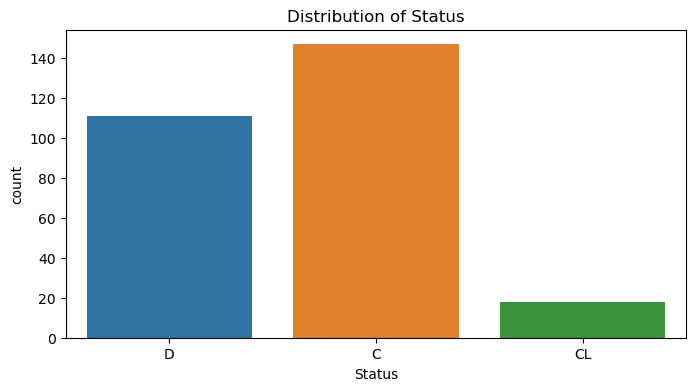

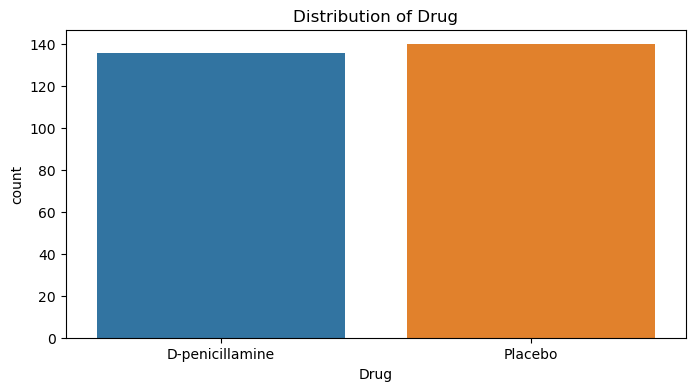

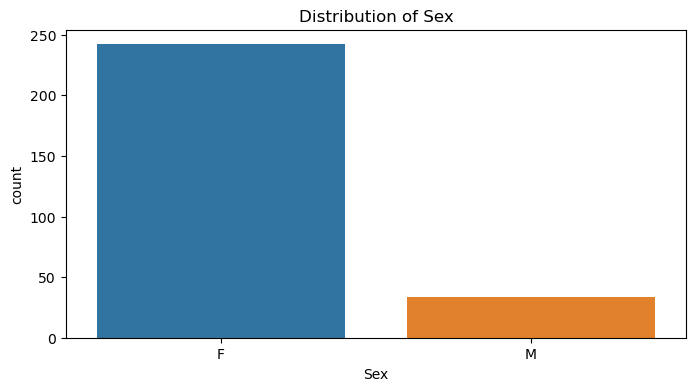

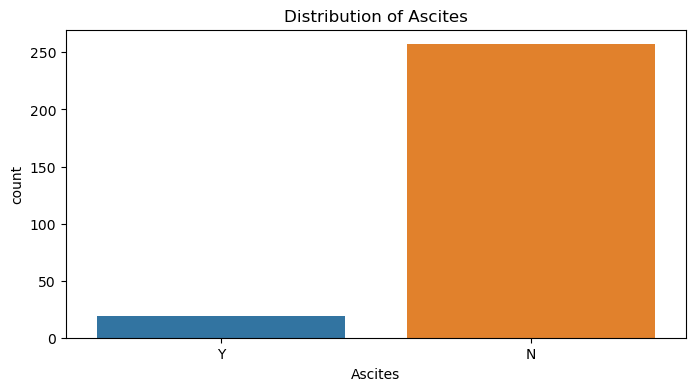

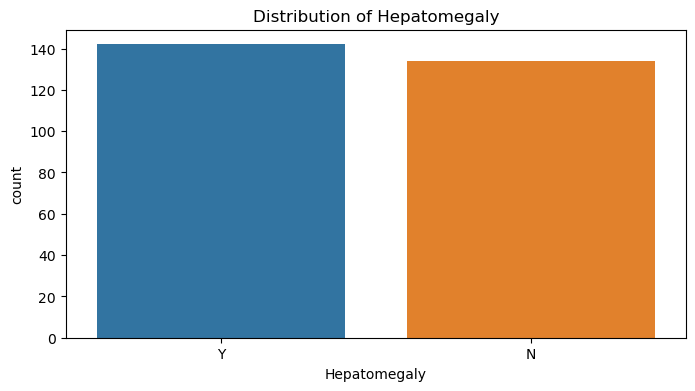

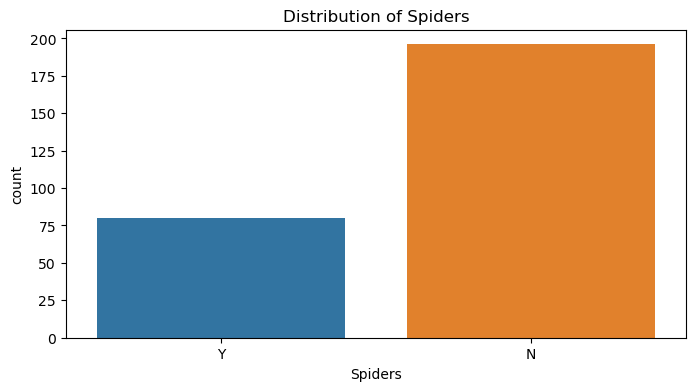

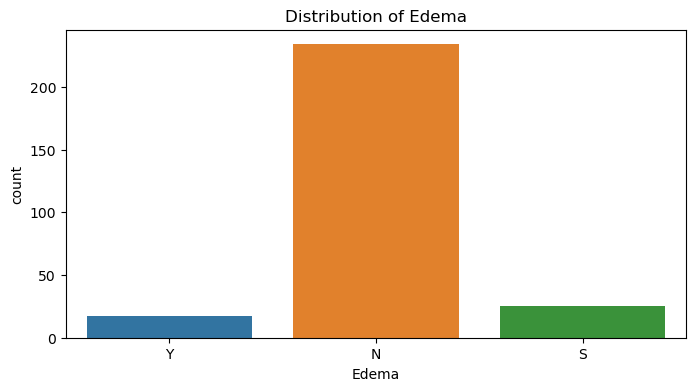

In [9]:
obj_col = df.select_dtypes('object')
for col in obj_col:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=col)
    plt.title(f'Distribution of {col}')
    plt.show()

#### Penicilamine
This medication is used to treat rheumatoid arthritis, Wilson's disease (a condition in which high levels of copper in the body cause damage to the liver, brain, and other organs), and a certain disorder which causes kidney stones (cystinuria). For the treatment of rheumatoid arthritis, penicillamine is known as a disease-modifying antirheumatic drug (DMARD).

#### Placebo
A placebo is anything that seems to be a "real" medical treatment -- but isn't. It could be a pill, a shot, or some other type of "fake" treatment. What all placebos have in common is that they do not contain an active substance meant to affect health.

#### Ascites
Ascites is a condition in which fluid collects in spaces within your abdomen. If severe, ascites may be painful. The problem may keep you from moving around comfortably. Ascites can set the stage for an infection in your abdomen. Fluid may also move into your chest and surround your lungs.

#### Hepatomegaly
An enlarged liver is one that's bigger than normal. The medical term is hepatomegaly (hep-uh-toe-MEG-uh-le). Rather than a disease, an enlarged liver is a sign of an underlying problem, such as liver disease, congestive heart failure or cancer. Treatment involves identifying and controlling the cause of the condition.

#### Spiders
Spider nevi, especially if there is more than one, is a common sign of liver disease. People with liver disease often have multiple vessel clusters at a time. Spider nevus commonly occurs when you have a lot of estrogen in your system, as is the case with chronic liver disease or during pregnancy.

#### Edema
Cirrhosis slows the regular flow of blood through the liver. This increases pressure in the vein that brings blood to the liver. Swelling in the legs and abdomen. The increased pressure in the portal vein can cause fluid to accumulate in the legs, called edema, and in the abdomen, called ascites

In [10]:
def age_range(age):
    if age in range(25, 30):
        return '25-30'
    elif age in range(31, 35):
        return '31-35'
    elif age in range(36, 40):
        return '36-40'
    elif age in range(41, 45):
        return '41-50'
    elif age in range(46, 50):
        return '46-50'
    elif age in range(51, 55):
        return '51-55'
    elif age in range(56, 60):
        return '55-60'
    elif age in range(61, 70):
        return '61-70'
    else:
        return 'Above 70'

In [11]:
df['Age_range'] = df['Age'].apply(age_range)
df['Age_range']

ID
1         55-60
2         55-60
3      Above 70
4      Above 70
5         36-40
         ...   
308       61-70
309       55-60
310       61-70
311       36-40
312       31-35
Name: Age_range, Length: 276, dtype: object

In [12]:
df.columns

Index(['N_Days', 'Status', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly',
       'Spiders', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage', 'Age_range'],
      dtype='object')

In [13]:
df[(df["Status"] == "D") & (df["Age_range"] == "55-60")][["SGOT", "Age_range"]]

,SGOT,Age_range
ID,,
1,137.95,55-60
12,82.15,55-60
22,120.90,55-60
23,227.04,55-60
142,134.85,55-60
156,201.50,55-60
162,127.10,55-60
193,161.20,55-60
227,179.80,55-60


In [14]:
Age_def = df.groupby('Age_range')[['Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']].agg(['mean', "std"])

In [15]:
Age_def

Bilirubin           Cholesterol               Albumin            \
               mean       std        mean         std      mean       std   
Age_range                                                                   
25-30      1.000000  0.000000  343.500000  147.785317  3.755000  0.021213   
31-35      3.056250  3.472937  488.937500  304.929821  3.722500  0.312932   
36-40      2.800000  3.594218  355.769231  160.790375  3.590769  0.347953   
41-50      3.321212  4.021564  504.878788  422.325686  3.544242  0.478983   
46-50      3.222222  4.809818  347.305556  131.120189  3.494167  0.287157   
51-55      4.586842  6.707083  401.105263  291.495658  3.587632  0.366115   
55-60      3.584375  5.812950  311.156250  144.855904  3.438438  0.452043   
61-70      3.382051  4.102751  338.435897  146.218437  3.458718  0.487783   
Above 70   2.775926  3.193326  317.518519  136.947138  3.448333  0.394599   

               Copper                 Alk_Phos                     SGOT  \
                 mean         std         mean          std        mean   
Age_range                                                                 
25-30       89.500000   17.677670  1502.500000   529.622979   84.325000   
31-35       92.187500   55.627594  2478.775000  3159.228321  134.263125   
36-40       99.653846   84.351618  1475.238462  1038.687506  118.978077   
41-50       95.303030   88.205543  2253.036364  1922.152805  151.501818   
46-50       97.805556   67.312414  2564.938889  2917.831326  129.290278   
51-55      121.657895  105.354556  2230.689474  2149.137706  126.768684   
55-60      109.000000  125.241959  1512.768750  1527.767608  106.220625   
61-70       98.692308   75.188589  2130.102564  2265.336527  123.782564   
Above 70    91.500000   83.821632  1613.081481  1715.502883  113.867037   

                     Tryglicerides               Platelets              \
                 std          mean         std        mean         std   
Age_range                                                                
25-30      18.844396    109.000000   11.313708  270.000000   59.396970   
31-35      41.389730    136.875000   78.852499  283.375000   63.343376   
36-40      48.658684    102.115385   35.039780  268.500000   91.373191   
41-50      75.384272    135.878788  100.212199  291.909091   88.733929   
46-50      49.945621    123.166667   48.097817  269.555556   99.687639   
51-55      62.577975    141.210526   74.017587  261.842105   77.106289   
55-60      49.071957    113.281250   51.880902  219.531250   75.514145   
61-70      57.977109    135.282051   74.141738  261.102564  102.500268   
Above 70   50.588266    115.666667   44.903250  253.685185  107.745652   

          Prothrombin            
                 mean       std  
Age_range                        
25-30       10.200000  0.000000  
31-35       10.418750  0.641060  
36-40       10.465385  0.654182  
41-50       10.521212  0.818061  
46-50       10.638889  0.898341  
51-55       10.894737  1.116933  
55-60       10.803125  1.016789  
61-70       11.058974  1.492035  
Above 70    10.788889  0.857743

In [16]:
Age_def.index

Index(['25-30', '31-35', '36-40', '41-50', '46-50', '51-55', '55-60', '61-70',
       'Above 70'],
      dtype='object', name='Age_range')

In [17]:
Age_def['Age_range'] = Age_def.index

In [18]:
for col in Age_def:
    print(col)

('Bilirubin', 'mean')
('Bilirubin', 'std')
('Cholesterol', 'mean')
('Cholesterol', 'std')
('Albumin', 'mean')
('Albumin', 'std')
('Copper', 'mean')
('Copper', 'std')
('Alk_Phos', 'mean')
('Alk_Phos', 'std')
('SGOT', 'mean')
('SGOT', 'std')
('Tryglicerides', 'mean')
('Tryglicerides', 'std')
('Platelets', 'mean')
('Platelets', 'std')
('Prothrombin', 'mean')
('Prothrombin', 'std')
('Age_range', '')


In [19]:
Age_def[col]

Age_range
25-30          25-30
31-35          31-35
36-40          36-40
41-50          41-50
46-50          46-50
51-55          51-55
55-60          55-60
61-70          61-70
Above 70    Above 70
Name: (Age_range, ), dtype: object

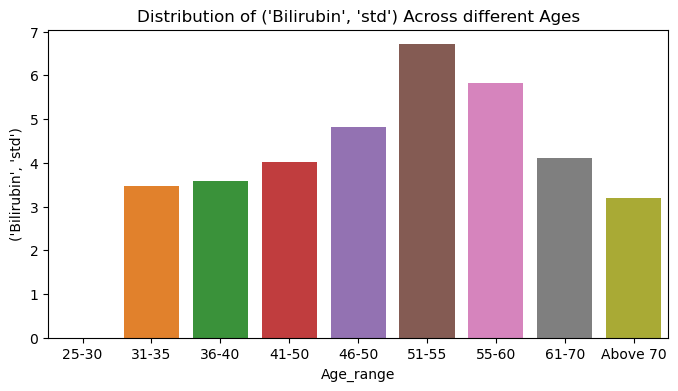

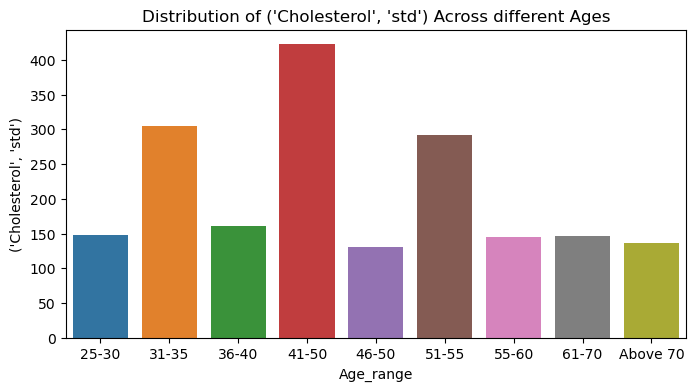

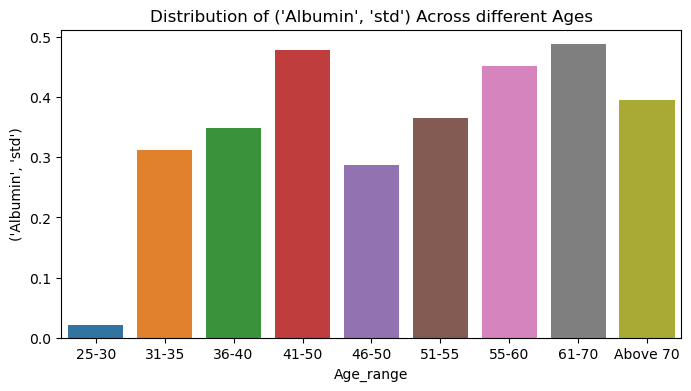

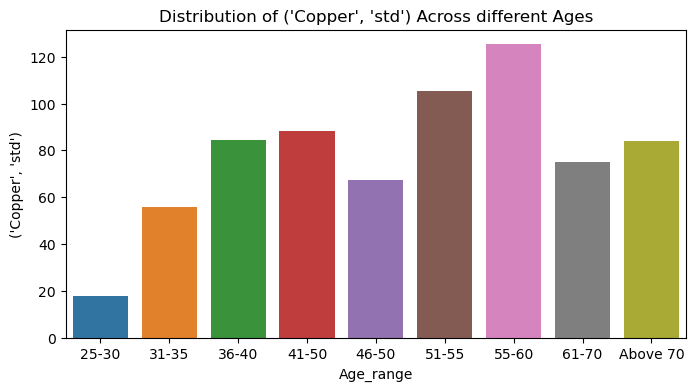

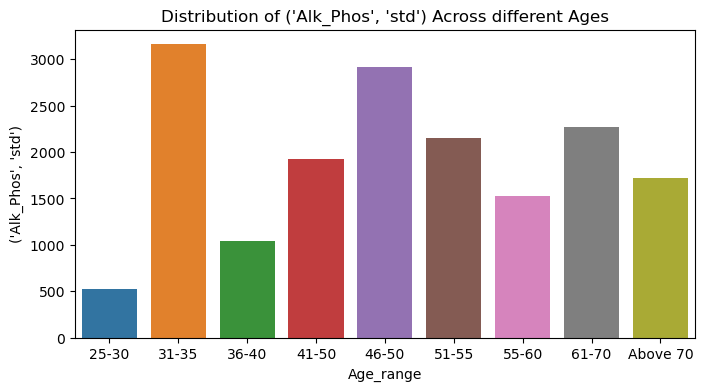

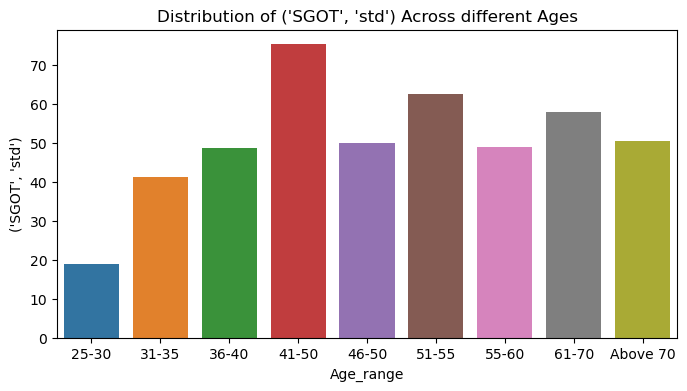

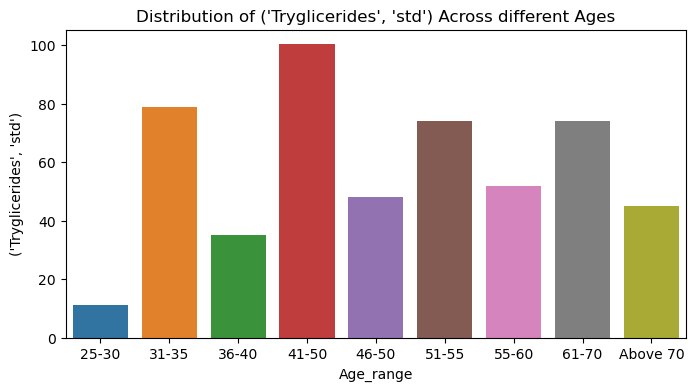

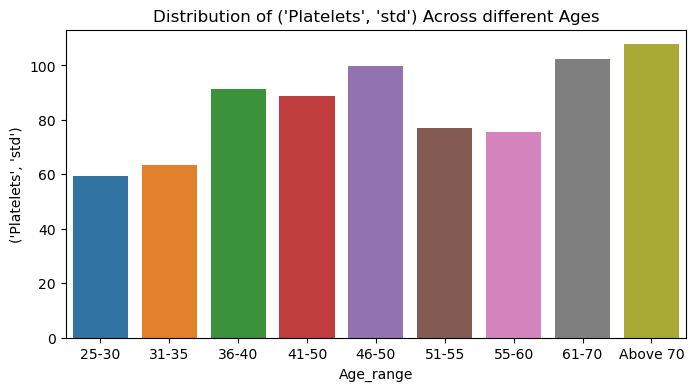

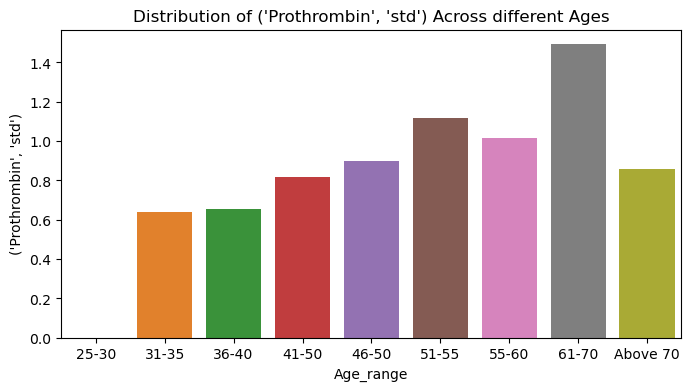

In [20]:
for col in Age_def:
    if col[1] == "std":
        plt.figure(figsize=(8, 4))
        sns.barplot(data=Age_def, x='Age_range', y=col)
        plt.title(f'Distribution of {col} Across different Ages')
        plt.show()

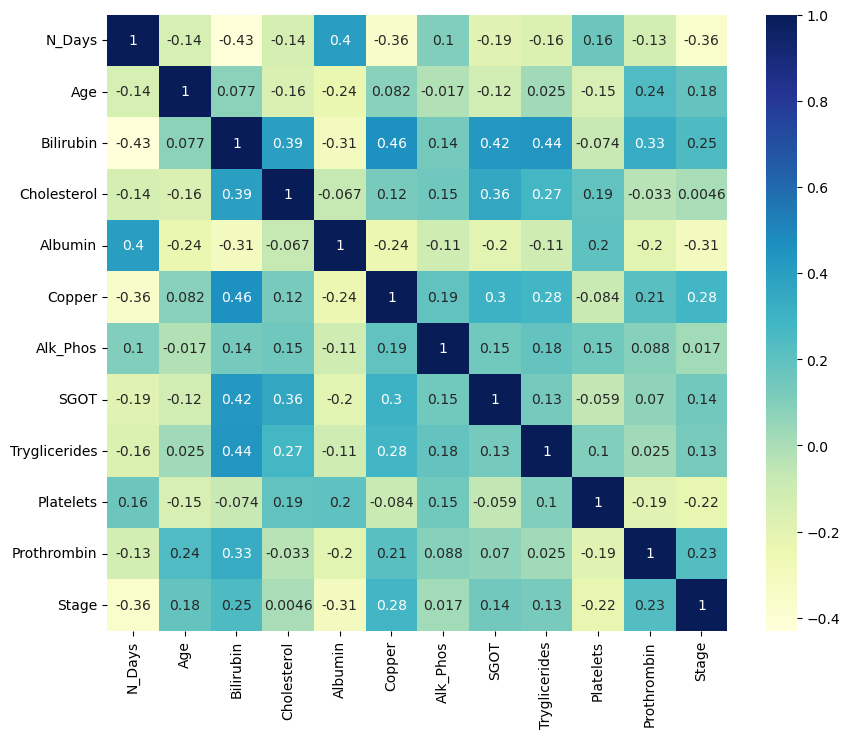

In [21]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True);

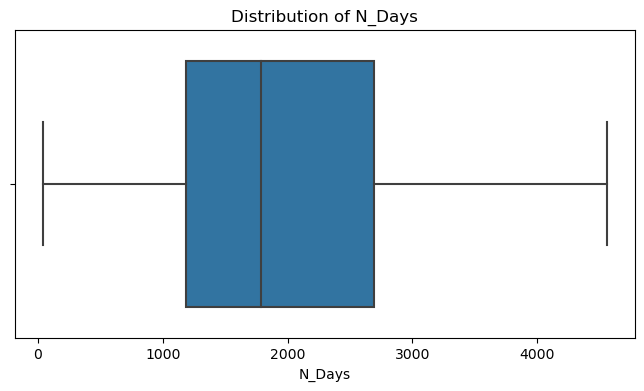

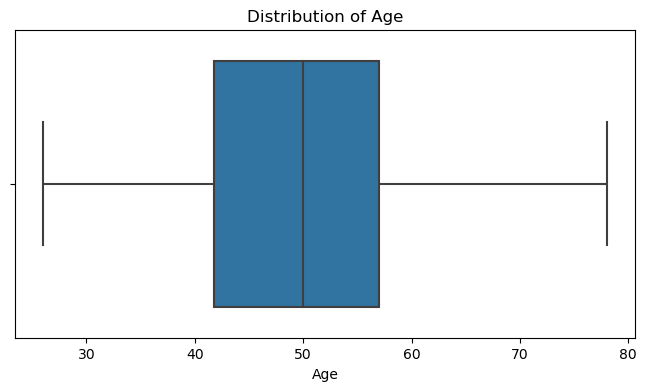

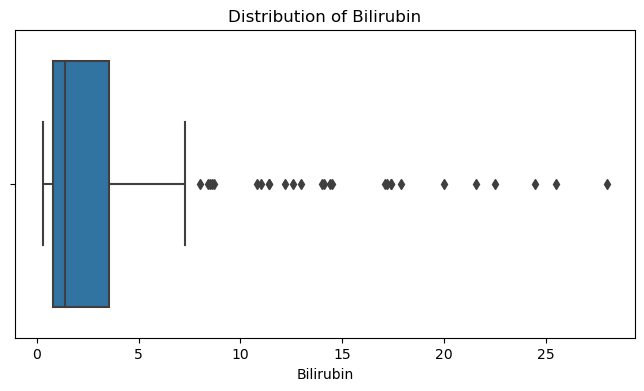

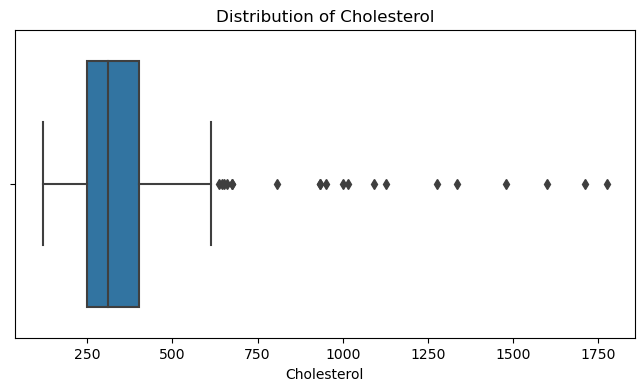

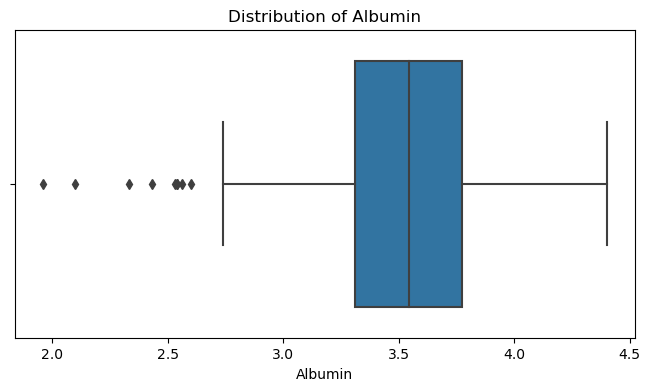

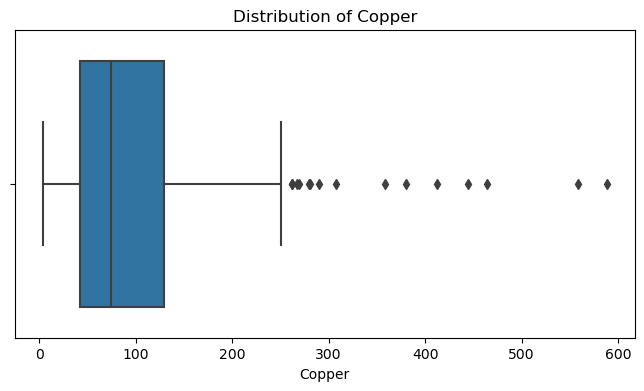

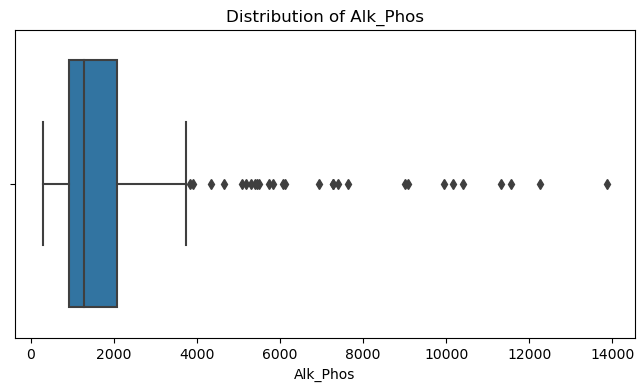

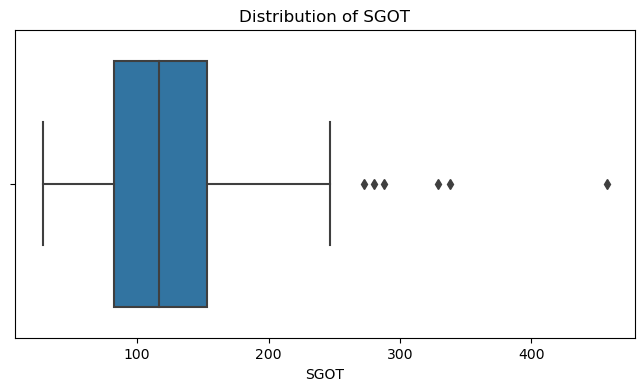

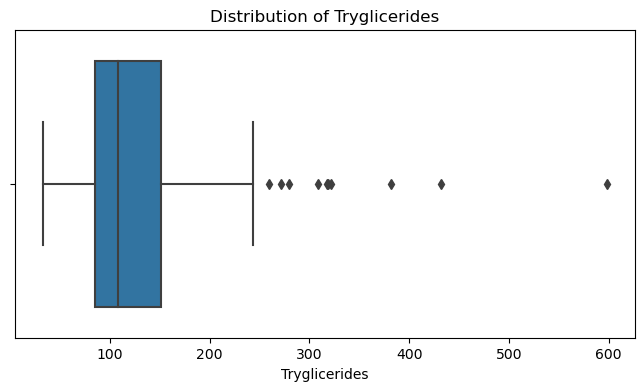

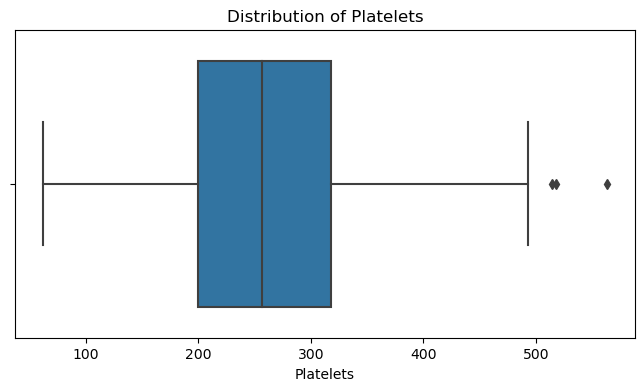

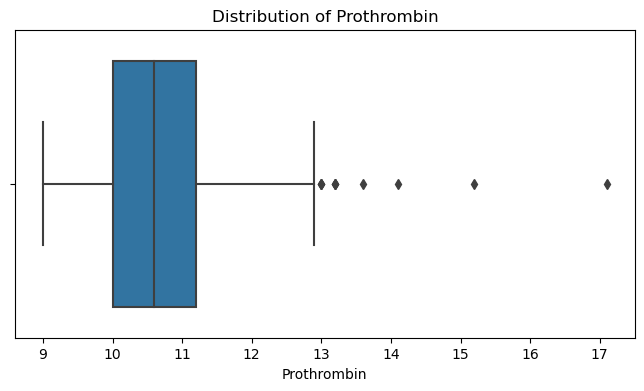

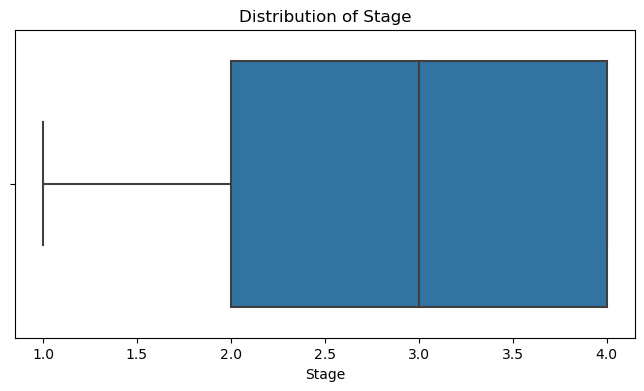

In [22]:
for col in num_col:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=num_col, x=col)
    plt.title(f'Distribution of {col}')
    plt.show()

In [23]:
df.drop(columns='Age_range', inplace=True)

## Machine Learning Workflow
### Split

In [24]:
df.columns

Index(['N_Days', 'Status', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly',
       'Spiders', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage'],
      dtype='object')

In [25]:
X = df.drop(columns='Status')
y= df['Status']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size =0.2,
    random_state=42
)

In [27]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

### Baseline

In [28]:
acc_baseline = y_train.value_counts(normalize=True).max()
print('Accuracy Baseline :', round(acc_baseline, 2))

Accuracy Baseline : 0.54


### Iterate

#### Decision Tree Classifier Model

In [29]:
# using HyperParameter Tuning
depth_hyperparams = range(1, 15)
training_acc = []
validation_acc = []

for d in depth_hyperparams:
    # Create model with `max_depth` of `d`
    model = make_pipeline(
        OneHotEncoder(use_cat_names=True),
        DecisionTreeClassifier(max_depth=d, random_state=42)
    )
    # Fit model to training data
    model.fit(X_train, y_train)
    # Calculate training accuracy score and append to `training_acc`
    training_acc.append(model.score(X_train, y_train))
    # Calculate validation accuracy score and append to `training_acc`
    validation_acc.append(model.score(X_val, y_val))
print(f"best validation score: {np.max(validation_acc):.3}")
best_max_depth = depth_hyperparams[np.argmax(validation_acc)]
print('Best max_depth:', best_max_depth)
print("Training Accuracy Scores:", training_acc)
print("Validation Accuracy Scores:", validation_acc)

best validation score: 0.727
Best max_depth: 3
Training Accuracy Scores: [0.7045454545454546, 0.7102272727272727, 0.7897727272727273, 0.8465909090909091, 0.8920454545454546, 0.8977272727272727, 0.9488636363636364, 0.9772727272727273, 0.9886363636363636, 1.0, 1.0, 1.0, 1.0, 1.0]
Validation Accuracy Scores: [0.6818181818181818, 0.6363636363636364, 0.7272727272727273, 0.6590909090909091, 0.6818181818181818, 0.6818181818181818, 0.7045454545454546, 0.7045454545454546, 0.6590909090909091, 0.6818181818181818, 0.6818181818181818, 0.6818181818181818, 0.6818181818181818, 0.6818181818181818]


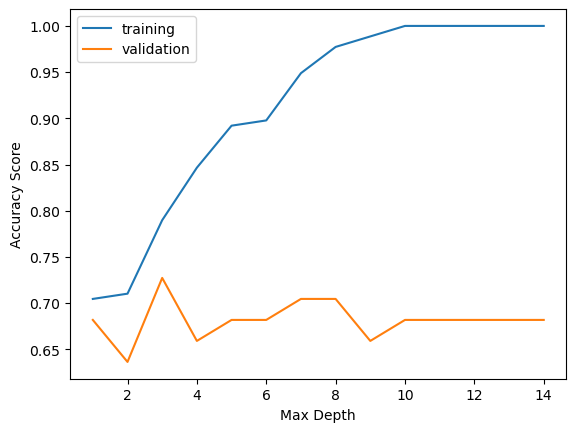

In [30]:
# Plot `depth_hyperparams`, `training_acc`
plt.plot(depth_hyperparams, training_acc, label='training')
plt.plot(depth_hyperparams, validation_acc, label='validation')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy Score')
plt.legend();

In [31]:
model = make_pipeline(
        OneHotEncoder(use_cat_names=True),
        DecisionTreeClassifier(max_depth= best_max_depth, random_state=42)
)
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Drug', 'Sex', 'Ascites', 'Hepatomegaly',
                                     'Spiders', 'Edema'],
                               use_cat_names=True)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=3, random_state=42))])

In [32]:
acc_test = model.score(X_test, y_test)
print('Test Accuracy :', round(acc_test, 2))

Test Accuracy : 0.73


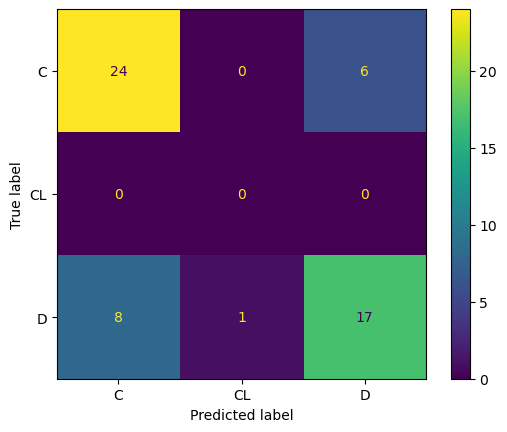

In [33]:
# plotting confusion Matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);

#### Random Forest Classifier Model

In [34]:
from sklearn.ensemble import RandomForestClassifier

In [35]:
R_model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    RandomForestClassifier(n_estimators=10, random_state=42),
)

R_model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Drug', 'Sex', 'Ascites', 'Hepatomegaly',
                                     'Spiders', 'Edema'],
                               use_cat_names=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=10, random_state=42))])

In [36]:
acc_train = R_model.score(X_train, y_train)
acc_test = R_model.score(X_test, y_test)

print('Training Accuracy :', round(acc_train, 2))
print('Test Accuracy :', round(acc_test, 2))

Training Accuracy : 0.99
Test Accuracy : 0.84


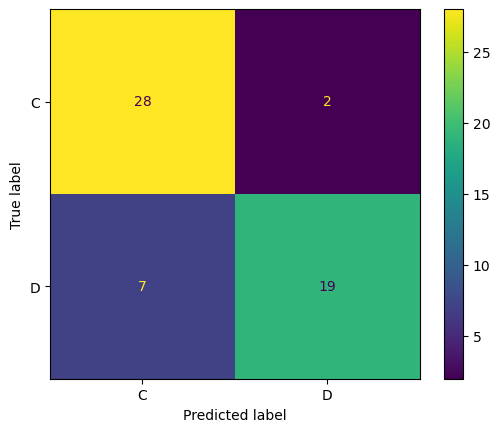

In [37]:
# plotting confusion Matrix
ConfusionMatrixDisplay.from_estimator(R_model, X_test, y_test);

#### Gradient Boosting Classifier Model

In [38]:
from sklearn.ensemble import GradientBoostingClassifier

In [39]:
Gr_model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    GradientBoostingClassifier(random_state=42, verbose=-1)
)
Gr_model.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Drug', 'Sex', 'Ascites', 'Hepatomegaly',
                                     'Spiders', 'Edema'],
                               use_cat_names=True)),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(random_state=42, verbose=-1))])

In [40]:
acc_train = Gr_model.score(X_train, y_train)
acc_test = Gr_model.score(X_test, y_test)

print('Training Accuracy :', round(acc_train, 2))
print('Test Accuracy :', round(acc_test, 2))

Training Accuracy : 1.0
Test Accuracy : 0.82


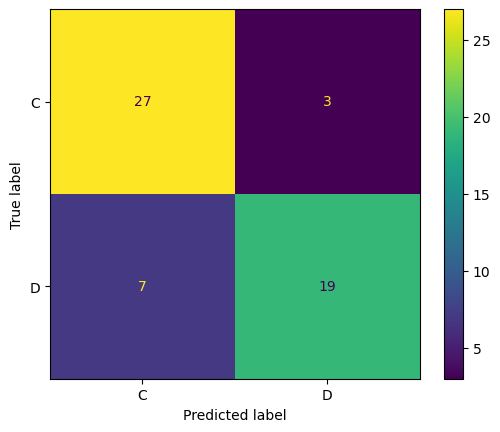

In [41]:
# plotting confusion Matrix
ConfusionMatrixDisplay.from_estimator(Gr_model, X_test, y_test);

#### KNeigbours Classifier Model

In [42]:
from sklearn.neighbors import KNeighborsClassifier

In [43]:
validation_acc = []
training_acc = []
# Specify a list of values we want to try for n_neighbors
# This might require some knowledge of the dataset and the model
# or potentially some trial-and-error
neighbors = np.arange(1, 15, 2)
# for each potential value of n_neighbors
for i in neighbors:
    # build a model
    Knn_model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    KNeighborsClassifier(n_neighbors= i)
    )
    Knn_model.fit(X_train, y_train)
    training_acc.append(Knn_model.score(X_train, y_train))
    # score validation set accuracy
    validation_acc.append(Knn_model.score(X_val, y_val))
# using max tells us the best score
print(f"best validation score: {np.max(validation_acc):.3}")
# with argmax we can find the best value of n_neighbors used
best_n_neighbors = neighbors[np.argmax(validation_acc)]
print("best n_neighbors:", best_n_neighbors)
print("Training Accuracy Scores:", training_acc)
print("Validation Accuracy Scores:", validation_acc)

best validation score: 0.773
best n_neighbors: 5
Training Accuracy Scores: [1.0, 0.7443181818181818, 0.7386363636363636, 0.7443181818181818, 0.7215909090909091, 0.7329545454545454, 0.7045454545454546]
Validation Accuracy Scores: [0.6136363636363636, 0.6590909090909091, 0.7727272727272727, 0.7727272727272727, 0.7272727272727273, 0.75, 0.7727272727272727]


In [44]:
Knn_model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    KNeighborsClassifier(n_neighbors=best_n_neighbors)
)
Knn_model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Drug', 'Sex', 'Ascites', 'Hepatomegaly',
                                     'Spiders', 'Edema'],
                               use_cat_names=True)),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [45]:
acc_train = Knn_model.score(X_train, y_train)
acc_test = Knn_model.score(X_test, y_test)

print('Training Accuracy :', round(acc_train, 2))
print('Test Accuracy :', round(acc_test, 2))

Training Accuracy : 0.74
Test Accuracy : 0.79


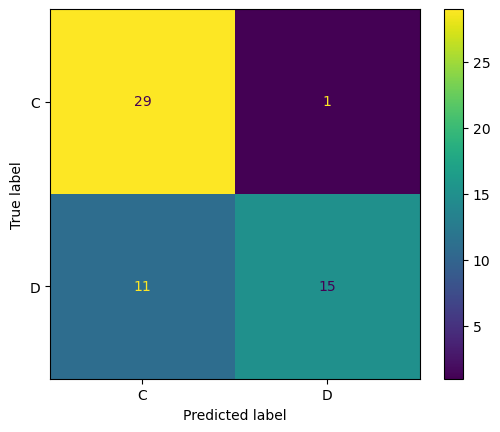

In [46]:
# plotting confusion Matrix
ConfusionMatrixDisplay.from_estimator(Knn_model, X_test, y_test);

##### Confusion matrix 

A confusion matrix is a tool for summarizing the performance of a classification algorithm. A confusion matrix will give us a clear picture of classification model performance and the types of errors produced by the model. It gives us a summary of correct and incorrect predictions broken down by each category. The summary is represented in a tabular form.

Four types of outcomes are possible while evaluating a classification model performance. These four outcomes are described below:-

True Positives (TP) – True Positives occur when we predict an observation belongs to a certain class and the observation actually belongs to that class.

True Negatives (TN) – True Negatives occur when we predict an observation does not belong to a certain class and the observation actually does not belong to that class.

False Positives (FP) – False Positives occur when we predict an observation belongs to a certain class but the observation actually does not belong to that class. This type of error is called Type I error.

False Negatives (FN) – False Negatives occur when we predict an observation does not belong to a certain class but the observation actually belongs to that class. This is a very serious error and it is called Type II error.

These four outcomes are summarized in a confusion matrix given below

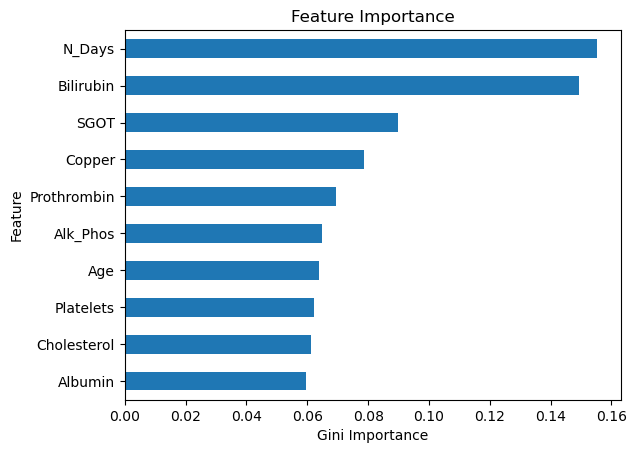

In [47]:
features = R_model.named_steps['onehotencoder'].get_feature_names()
# Extract importances from model
importances = R_model.named_steps['randomforestclassifier'].feature_importances_
# Create a series with feature names and importances
feat_imp = pd.Series(importances, index=features).sort_values()
# Plot 10 most important features
feat_imp.tail(10).plot(kind='barh')
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");

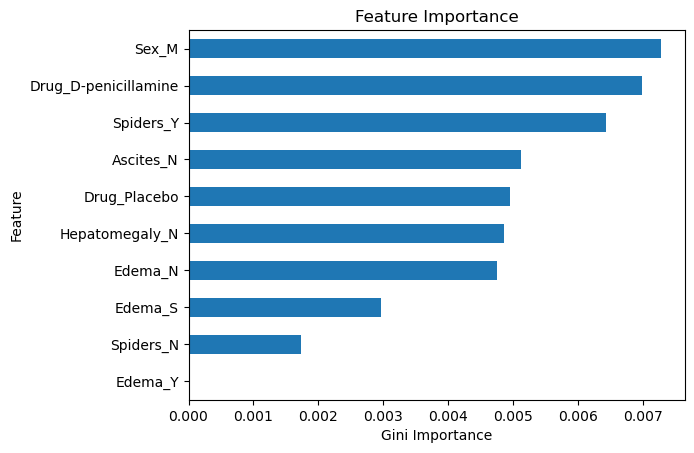

In [48]:
features = R_model.named_steps['onehotencoder'].get_feature_names()
# Extract importances from model
importances = R_model.named_steps['randomforestclassifier'].feature_importances_
# Create a series with feature names and importances
feat_imp = pd.Series(importances, index=features).sort_values()
# Plot 10 most important features
feat_imp.head(10).plot(kind='barh')
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");